In [1]:
import re
import pymorphy2
import pandas as pd
import numpy as np
from gensim.models import LdaModel
from gensim.test.utils import datapath
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize # https://github.com/natasha/razdel
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

# from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [2]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
    на выходе лист отлемматизированых токенов
    '''

    # если зашел тип не `str` делаем его `str`
    if not isinstance(text, str):
        text = str(text)
    
    # токенизация предложения через razdel
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        # проверка есть ли в начале слова '-'
        if w[0] == '-':
            w = w[1:]
        # проверка токена с одного символа
        if len(w)>1:
            # проверка есть ли данное слово в кэше
            if w in cache:
                words_lem.append(cache[w])
            # лемматизация слова
            else: 
                # проверка на стоп-слова
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [3]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    font = {'size' : 15}
    plt.rc('font', **font)
    plt.figure(figsize=(10, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [5]:
def print_results(y_t, p):
    precision, recall, thresholds = precision_recall_curve(y_t, p)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    rs = roc_auc_score(y_t, p)
    print(f'Best Threshold={thresholds[ix]:.3}, F-Score={fscore[ix]:.3}, Precision={precision[ix]:.3}, Recall={recall[ix]:.3}, roc_auc_score={rs:.3}' )
    cnf_matrix = confusion_matrix(y_t, p>thresholds[ix])
    
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')

In [6]:
users = pd.read_csv("./input/users_articles.csv")
news = pd.read_csv("./input/articles.csv")
target = pd.read_csv("./input/users_churn.csv")
stopword_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()
with open('input/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
# len(stopword_ru)

In [7]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)


<ipython-input-2-a3802ddc1a4f>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 24.7 s


In [8]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 5s


In [9]:
#сформируем список наших текстов, разбив еще и на пробелы
texts =  [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [10]:
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

In [11]:
topics = ['topic_{}'.format(i) for i in range(25)]

topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = topics
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id'] + topics]
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[topics].values))
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.063657,...,0.0,0.0,0.016809,0.000000,0.911797,0.000000,0.0,0.000000,0.0,0.0
1,4896,0.0,0.0,0.472789,0.0,0.000000,0.000000,0.000000,0.000000,0.503608,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,4897,0.0,0.0,0.000000,0.0,0.028059,0.000000,0.220611,0.000000,0.501992,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.230489,0.0,0.0
3,4898,0.0,0.0,0.000000,0.0,0.000000,0.033743,0.056171,0.074461,0.149185,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.517197,0.0,0.0
4,4899,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.743910,0.000000,0.138912,...,0.0,0.0,0.000000,0.057455,0.000000,0.036357,0.0,0.000000,0.0,0.0


In [12]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [13]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = topics
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+topics]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.020277,0.0,0.255258,0.037037,0.010340,0.000000,0.010949,0.027989,0.000000,...,0.084208,0.029574,0.016404,0.018956,0.081367,0.039947,0.000000,0.032677,0.0,0.000000
1,u108690,0.039477,0.0,0.058758,0.009257,0.015469,0.028413,0.050753,0.060951,0.003816,...,0.131946,0.009408,0.000000,0.060829,0.274241,0.001808,0.008116,0.090891,0.0,0.001920
2,u108339,0.083645,0.0,0.185758,0.007271,0.009766,0.001699,0.080489,0.050112,0.006111,...,0.064744,0.036500,0.000000,0.052979,0.216471,0.009032,0.002957,0.000000,0.0,0.001795


In [14]:
X = pd.merge(user_embeddings, target, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[topics],  X['churn'], random_state=0)

In [15]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

Best Threshold=0.696, F-Score=nan, Precision=0.0, Recall=0.0, roc_auc_score=0.945
Confusion matrix, without normalization
[[1755    0]
 [ 245    0]]


<ipython-input-5-2b42625d602c>:3: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


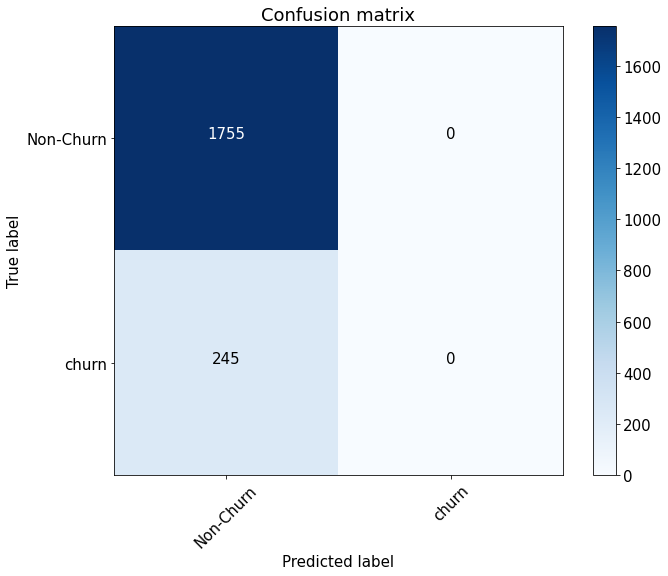

In [16]:
 print_results(y_test, preds)

### Задание 1
Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)


### Задание 2
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана.  
Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [17]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [18]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = topics
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+topics]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.258441,0.014299,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.045451,0.0,0.0,0.000000,0.0,0.0
1,u108690,0.024891,0.0,0.048101,0.000000,0.007983,0.00953,0.016813,0.063075,0.0,...,0.107057,0.000000,0.0,0.069462,0.286713,0.0,0.0,0.053472,0.0,0.0
2,u108339,0.060705,0.0,0.212147,0.000000,0.000000,0.00000,0.027804,0.051168,0.0,...,0.022994,0.023326,0.0,0.059077,0.195500,0.0,0.0,0.000000,0.0,0.0


In [19]:
X = pd.merge(user_embeddings, target, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[topics],  X['churn'], random_state=0)

In [20]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

Best Threshold=0.298, F-Score=0.779, Precision=0.725, Recall=0.841, roc_auc_score=0.972
Confusion matrix, without normalization
[[1677   78]
 [  40  205]]


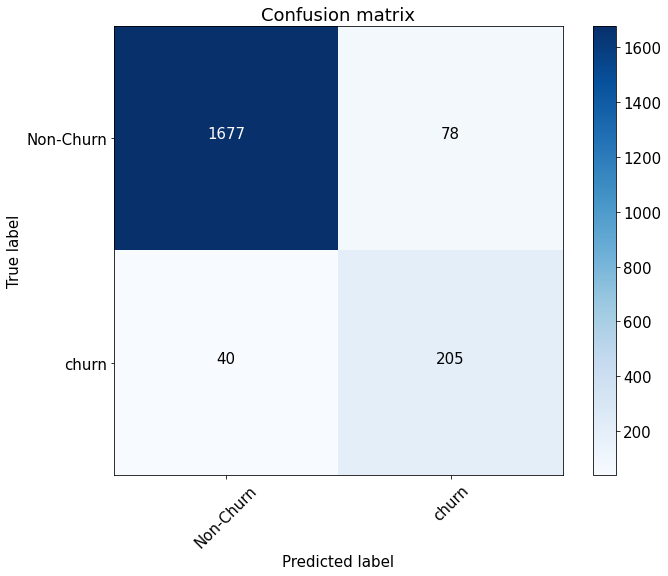

In [21]:
print_results(y_test, preds)

### Задание 3
Повторить п.2, но используя уже не медиану, а max

In [22]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [23]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = topics
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+topics]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.076389,0.0,0.479896,0.119955,0.062041,0.000000,0.065694,0.103353,0.000000,...,0.398483,0.119182,0.087369,0.113734,0.209426,0.216152,0.000000,0.177869,0.0,0.000000
1,u108690,0.124331,0.0,0.142223,0.042429,0.045554,0.105760,0.189586,0.141982,0.022894,...,0.333133,0.056445,0.000000,0.101936,0.446124,0.010847,0.048699,0.320329,0.0,0.011521
2,u108339,0.247057,0.0,0.355413,0.043627,0.046985,0.010195,0.251294,0.111411,0.018381,...,0.187028,0.090621,0.000000,0.120378,0.486777,0.054195,0.017741,0.000000,0.0,0.010772


In [24]:
X = pd.merge(user_embeddings, target, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[topics],  X['churn'], random_state=0)

In [25]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

Best Threshold=0.308, F-Score=0.821, Precision=0.794, Recall=0.849, roc_auc_score=0.979
Confusion matrix, without normalization
[[1701   54]
 [  38  207]]


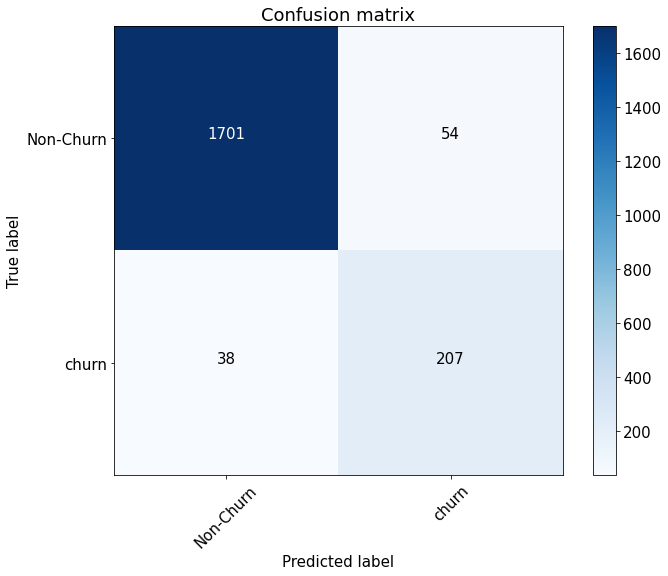

In [26]:
print_results(y_test, preds)

### Задание 4*
Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа.  
Не все документы одинаково информативны и несут какой-то положительный сигнал).  
Подсказка 2 - нужен именно idf, как вес.

### Задание 5*
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

### Задание 6
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных